# Evaluation of CAE

In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/0_preProcessing")
sys.path.append("/data/tim/heronWorkspace/1_AE")
sys.path.append("/data/tim/heronWorkspace/2_postProcessing")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModel import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from PostProcessingHelper import MinFilter, CheckPoints, PostProcess
import glob
from pathlib import Path
import os

colors = [
    "#32829C",
    "#E38538",
    "#51AC8C",
    "#D94841",
    "#7A5C96"
]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Raw CAE Result
without the computer vision part

In [5]:
def computeSumCAERaw(params: dict, loaderParams: dict, checkPoint = None):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    if checkPoint is None:
        checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
    caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
    caeLoaded.freeze()
  
    
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    sumVals = []
    lblVals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:

        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


        # prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
    
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred.to(prevPred.device), pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImg, currImg, nextImg], [prevPred, currPred, nextPred])]

        sumArr = torch.sum(currImd, dim=(1, 2))
        # prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        # nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        # prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        # prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=params["minFilterKernelSize"]) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        # # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        # sumZeroThresholdArr = [torch.sum(torch.where(prevNextCurrImdMin < zeroThreshold, torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin), dim=(1, 2)).numpy(force=True) for zeroThreshold in zeroThresholdArr]
        # sumZeroThresholdArr = np.array(sumZeroThresholdArr) # shape: (len(zeroThresholdArr), batch_size)

        
        # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

        # for i in range(sumZeroThresholdArr.shape[1]):
        #     sumVals.append(sumZeroThresholdArr[:, i])
        #     lblVals.append(lblArr[i].item())
    
        sumVals= np.concatenate((sumVals, sumArr.to("cpu").detach().numpy()))
        lblVals = np.concatenate((lblVals, lblArr.to("cpu").detach().numpy()))

        # imagePaths += list(ImagePath)
    
    
    return np.array(sumVals), np.array(lblVals)





In [6]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],#["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    # zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

zeroThresholdArr = np.arange(start=0.1, stop = 0.5, step=0.1) # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
# sumThresholdArr = np.arange(start=5, stop=100, step=10)

sumVals, lblVals = computeSumCAERaw(params=startState, loaderParams=loaderParams, checkPoint=CheckPoints.bestGlobal)
print("successfully computed sumVals and lblVals")

/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 112
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'lossFn': 'L1'}
successfully computed sumVals and lblVals


In [21]:
sumVals

array([ 9545.33203125, 15045.13671875, 10521.05078125,  8679.33789062,
       12598.30078125, 16962.98632812,  9253.30078125,  6653.60449219,
       22585.65820312, 12872.91894531, 13715.51953125, 12295.70410156,
       10879.20898438,  8793.97558594, 10065.29785156, 10475.13378906,
        8731.875     ,  9555.56445312, 11975.03417969, 12979.45703125,
        8399.03320312, 16262.17480469, 14319.25488281, 12553.43554688,
       13520.87988281,  8746.76171875, 19042.1171875 ,  9714.62890625,
       11038.73046875, 24123.90039062, 17527.45117188, 16184.55175781,
       19726.578125  , 13992.68457031,  9382.20605469, 10217.74023438,
        8740.99121094, 12664.64160156,  9667.55078125,  9271.2578125 ,
        8909.76464844, 10810.42871094,  8536.07324219, 10156.52148438,
       25200.53125   , 10242.77929688,  9960.74609375,  8538.67773438,
       20906.24804688,  8789.20605469, 10278.79492188,  8698.71484375,
       14062.69726562,  8815.69726562, 10060.03027344, 18146.21875   ,
      

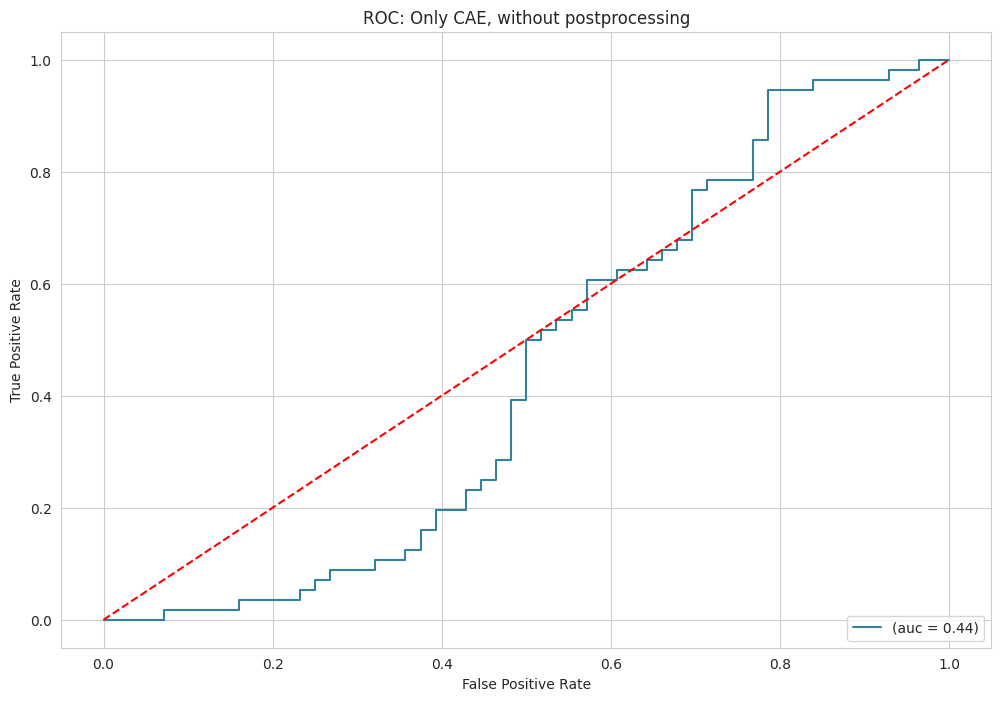

In [7]:
plt.figure(figsize = (12,8)) 

fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
roc_auc = roc_auc_score(lblVals, sumVals)
plt.plot(fpr, tpr, label=f'auc = {roc_auc:0.2f}')

plt.plot([0, 1], [0, 1],'r--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC: Only CAE, without postprocessing') 
plt.legend(loc="lower right") 
plt.show()

## Different CAE's

In [41]:
def computeSum(params: dict, loaderParams: dict, checkPoint = None):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    if checkPoint is None:
        checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
    caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
    caeLoaded.freeze()
  
    
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    sumVals = []
    lblVals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:

        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
    
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        minFilter = MinFilter(kernelSize=params["minFilterKernelSize"])
        prevNextCurrImdMin = torch.stack([minFilter(x) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        # sumZeroThreshold = torch.sum(torch.where(prevNextCurrImdMin < zeroThreshold, torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin), dim=(1, 2)).numpy(force=True)
        # sumZeroThresholdArr = np.array(sumZeroThresholdArr) # shape: (len(zeroThresholdArr), batch_size)

        
        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

        sumVals = np.concatenate((sumVals, sumPrevNextCurrImdMin.to("cpu").detach().numpy()))
        lblVals = np.concatenate((lblVals, lblArr.to("cpu").detach().numpy()))
    
        # imagePaths += list(ImagePath)
    
    
    return np.array(sumVals), np.array(lblVals)





# Performance on unseen dataset

In [49]:
# wanted checkpoints
path = '/data/tim/heronWorkspace/logs/BasicCAE1/' # use your path
ckptList = []
for i in range(2, 6):
    ckptList.append(glob.glob(os.path.join(path, f"version_{i}", "checkpoints", "*.ckpt"))[-1])


loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],#["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

 # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image


sumValsListAll = []
lblValsListAll = []

for ckpt in ckptList:
    # caeLoaded = CAEHeron.load_from_checkpoint(ckpt, model = model)
    # caeLoaded.freeze()
    # trainer = pl.Trainer()
    # trainer.test(caeLoaded)
    
    sumVals, lblVals = computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListAll.append(sumVals)
    lblValsListAll.append(lblVals)

loaderParams["anomalyObviousness"] = "obvious"
sumValsListObv = []
lblValsListObv= []
for ckpt in ckptList:
    # caeLoaded = CAEHeron.load_from_checkpoint(ckpt, model = model)
    # caeLoaded.freeze()
    # trainer = pl.Trainer()
    # trainer.test(caeLoaded)
    
    sumVals, lblVals = computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListObv.append(sumVals)
    lblValsListObv.append(lblVals)
    
print("successfully computed sumVals and lblVals")


/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 258
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 258
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
/data/tim/heronWorkspace/manuallyClassified/manuallyCl

In [54]:
print(sumValsListAll[0][:10])
print(sumValsListObv[0][:10])

[0.         0.         0.         0.         0.22188006 0.
 3.37358093 6.88366985 4.49461651 0.        ]
[  0.         202.68603516   0.           0.           0.
   0.           0.           0.20632309   2.9254818    0.        ]


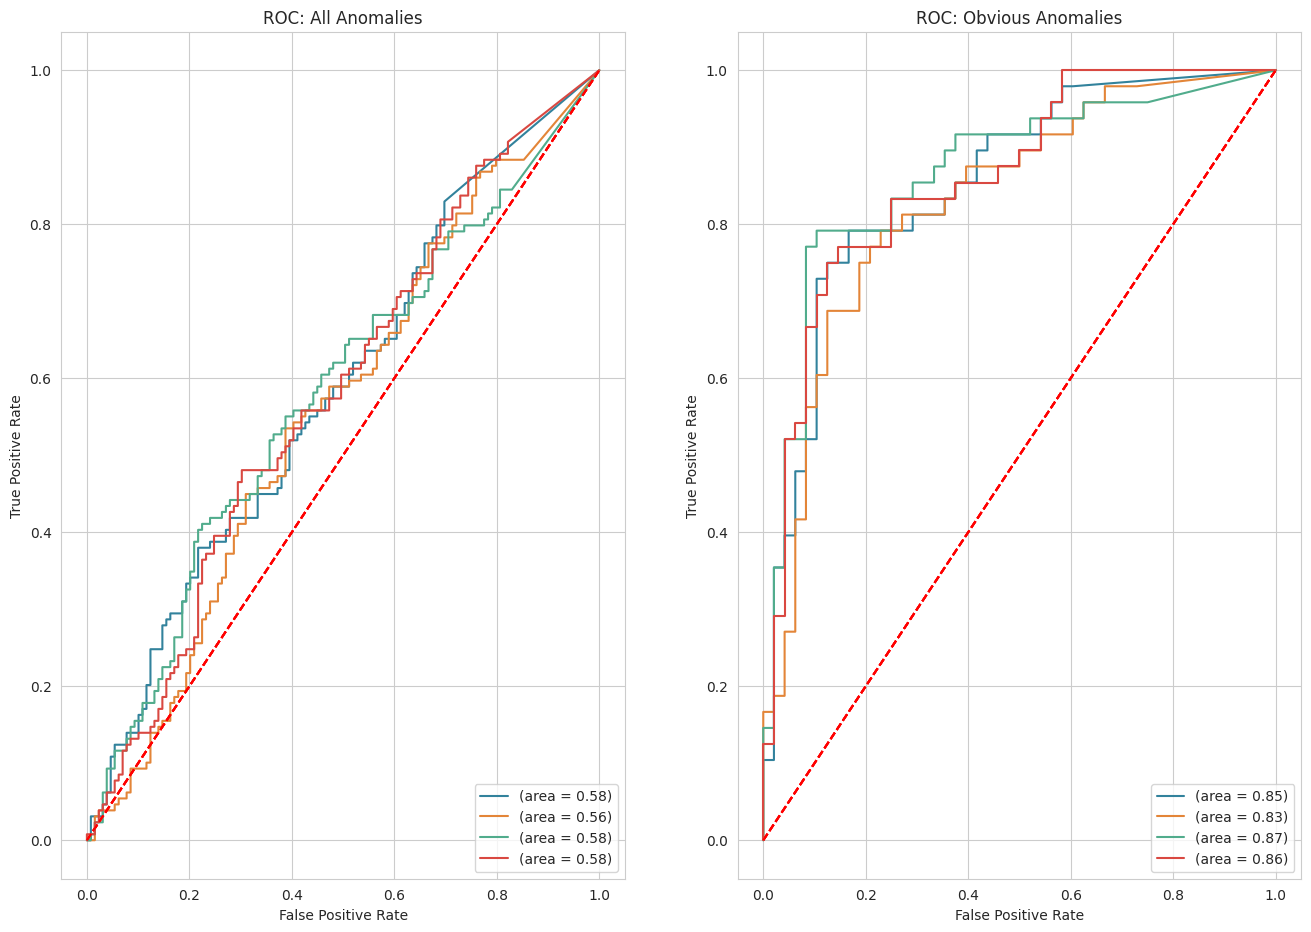

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (16,11)) 
for sumVals, lblVals in zip(sumValsListAll, lblValsListAll):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    ax[0].plot(fpr, tpr, label=f'(auc = {roc_auc:0.2f})')

    ax[0].plot([0, 1], [0, 1],'r--') 
    ax[0].set_xlabel('False Positive Rate') 
    ax[0].set_ylabel('True Positive Rate') 
    ax[0].set_title('ROC: All Anomalies') 
    ax[0].legend(loc="lower right")

for sumVals, lblVals in zip(sumValsListObv, lblValsListObv):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    ax[1].plot(fpr, tpr, label=f'(auc = {roc_auc:0.2f})')

    ax[1].plot([0, 1], [0, 1],'r--') 
    ax[1].set_xlabel('False Positive Rate') 
    ax[1].set_ylabel('True Positive Rate') 
    ax[1].set_title('ROC: Obvious Anomalies') 
    ax[1].legend(loc="lower right")

plt.legend(loc="lower right") 
plt.show()